# 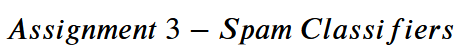

In [105]:
import numpy as np
import pandas as pd
import math
from sklearn import svm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the Spam Mails dataset from Kaggle

Dataset courtesy of $Venkatesh$ $Garnepudi$ <i>via</i> $Kaggle$

In [106]:
df =   pd.read_csv('a3.csv')
df.columns = ['index', 'label', 'text', 'label_num']
X = df['text'].values
y = df['label_num'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print(len(X_test))

1035


In [125]:
df

,index,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


## Preprocessing

In [107]:
# deleting symbols that are mostly uncorrelted between spam and ham usually (in english) to decrease data 
def del_sym(word):
  syms = [",", ".", "?", "!", "'", "+", "(", ")", "{", "}", ";" , "\\", "/", ":", "-", "=", "_", "@", "$", "%", "^", "&", "*", "#"]
  new_word = ""
  for character in word:
    if(character not in syms):
      new_word = new_word + character
  return new_word

# Eliminating less significant words that are used in general (that build up the enlish sentences)
def fstopwords(list_of_words):
  StopWords = set(stopwords.words('english'))
  filtered = []
  for word in list_of_words:
    if(word.lower() not in StopWords):
      filtered.append(word)
  return filtered

# Considering Numbers are weakly sinificant in classifiying spam
def del_num(word):
  return(''.join([i for i in word if not i.isdigit()]))

In [108]:
s = set(stopwords.words('english'))
print(len(s))

179


In [109]:
def preprocess(text):
    tokens = []
    for word in text.split():
        word = del_sym(word)
        word = del_num(word)
        tokens.append(word.lower())
    tokens = fstopwords(tokens)
    tokens = [token for token in tokens if token]
    tokens = set(tokens)

    return list(tokens)

In [110]:
dictionary = []
tokens_list = []
for email in X_train:
  tokens = preprocess(email)
  tokens_list.append(tokens)
  dictionary = dictionary + tokens
dictionary = list(set(dictionary))
print(len(dictionary))

39133


In [113]:
len(dictionary)/sum

0.14999750853804847

In [142]:
sum = 0
for i in range(len(tokens_list)):
    sum += len(tokens_list[i])

In [115]:
def features(email_tokens, unique_words):
  temp = np.arange(len(unique_words))
  j=0
  for word in unique_words:
    temp[j] = int(word in email_tokens)
    j = j+1
  return temp

In [116]:
feature_vec = np.zeros((len(tokens_list), len(dictionary)))
i=0
for email_tokens in tokens_list:
  feature_vec[i] = features(email_tokens, dictionary)
  i = i+1
feature_vec = np.array(feature_vec, dtype = object)

# Code: Spam detection using multiple methods

## Naive Bayes Classifier

In [120]:
train_spam = [i for i in range(len(X_train)) if y_train[i] == 1]
train_ham = [i for i in range(len(X_train)) if y_train[i] == 0]
train_spam_tokens = [tokens_list[i] for i in train_spam]
train_ham_tokens = [tokens_list[i] for i in train_ham]

In [121]:
prob_spam_ham = len(train_spam)/(len(train_spam)+ len(train_ham))
print(prob_spam_ham)

0.28916827852998067


In [122]:
def predict_NB(email):
  test_email_tokens = preprocess(email)
  n = 0
  prob_spam = math.log(prob_spam_ham)
  prob_ham = math.log(1-prob_spam_ham)
  for token in test_email_tokens:
    #no. of spam emails containing word
    count_spam = 0
    #no. of ham emails containing word
    count_ham = 0
    for spam_tokens in train_spam_tokens:
      if token in spam_tokens:
        count_spam = count_spam + 1
    for ham_tokens in train_ham_tokens:
      if token in ham_tokens:
        count_ham = count_ham + 1
    if(count_spam == 0 and count_ham == 0):
      pass
    prob_spam += math.log((count_spam + 1) / (len(train_spam) + 2))
    prob_ham += math.log((count_ham + 1) / (len(train_ham) + 2))
  if(prob_spam > prob_ham):
    return 1
  else:
    return 0

In [123]:
count = 0
for i in range(len(X_test)):
  email = X_test[i]
  if(predict_NB(email) == y_test[i]):
    count = count+1
    #print(df_test.iloc[i,1])
print((count/len(y_test))*100)

93.33333333333333


## Logistic Regression using $Sigmoid$ Link function

In [129]:
def fsigmoid(x,w):
  return (1/(1 + np.exp(-1*np.dot(x,w))))

In [130]:
# singe gradient update
def gradient_update(X, y, w, learning_rate):
  grad = 0
  i = 0
  for i in range(len(X)):
    grad = grad + X[i]*(y[i] - fsigmoid(X[i],w))
    i += i
  return grad

# to update w of the linear vector
def gradient_descent(X,y, learning_rate, number_of_epochs):
  w = [0]*X.shape[1]
  w = np.array(w)
  print(w.shape)
  for i in range(number_of_epochs):
    w = w + learning_rate*gradient_update(X,y,w,learning_rate)
  return w

In [131]:
mail_train = []
for email in X_train:
  mail_train.append(features(email, dictionary))

X_train_features = np.array(mail_train)
w_gd = gradient_descent(X_train_features, y_train, 0.01, 200)

(39133,)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7196\2458912821.py:2: RuntimeWarning: overflow encountered in exp
  return (1/(1 + np.exp(-1*np.dot(x,w))))


In [132]:
def predict_logistic(email):
  email_features = features(email, dictionary)
  if(fsigmoid(email_features, w_gd)>0.5):
    return 1
  else:
    return 0

In [133]:
i = 100
print(str(predict_logistic(X_test[i])) + " " + str(y_test[i]))

0 0


In [134]:
count = 0  
for i in range(len(y_test)):
  if(predict_logistic(X_test[i]) == y_test[i]):
    count = count+1
print('test score: ',count/len(y_test))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7196\2458912821.py:2: RuntimeWarning: overflow encountered in exp
  return (1/(1 + np.exp(-1*np.dot(x,w))))


test score:  0.9642512077294686


## Using Sci-Kit for more complex models

## SVM :

In [135]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [136]:
def calcFScore(xTest, yTest, model, vectorizer):
    
    xTestMatrix = vectorizer.transform(xTest)
    yTestMatrix = np.asarray(yTest)

    result = model.predict(xTestMatrix)
    matrix = confusion_matrix(yTestMatrix, result)

    precision = precision_score(yTestMatrix, result, pos_label=0)
    return  precision, matrix

In [137]:
xTrain, xTest, yTrain, yTest = X_train, X_test, y_train, y_test

model = LinearSVC(class_weight='balanced')

vectorizer = TfidfVectorizer(stop_words='english', max_df=75)
yTrainMatrix = np.asarray(yTrain)
xTrainMatrix = vectorizer.fit_transform(xTrain)

# Training SVM classifier
model.fit(xTrainMatrix, yTrainMatrix)
precision, matrix = calcFScore(xTest, yTest, model, vectorizer)
print(precision, '\n Confusion matrix:\n ', '   spam, ham\nspam',matrix[0,:],'\nham ',matrix[1,:])

0.979757085020243 
 Confusion matrix:
     spam, ham
spam [726   6] 
ham  [ 15 288]


## Ensemble Models :

In [140]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

### Bagging

In [139]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=75)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Ensure consistent preprocessing


bagging_classifier = BaggingClassifier(base_estimator=LinearSVC(class_weight='balanced'), n_estimators=100, random_state=42)
bagging_classifier.fit(X_train_vectorized, y_train)


y_pred_bagging = bagging_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred_bagging)
print("Bagging Accuracy:", accuracy)


D:\Santosh\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy: 0.9758454106280193


### Boosting

In [141]:
ada_classifier = AdaBoostClassifier(base_estimator=LinearSVC(class_weight='balanced'), n_estimators=100, random_state=42, algorithm='SAMME')
ada_classifier.fit(X_train_vectorized, y_train)
y_pred_ada = ada_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred_ada)
print("AdaBoost (SAMME) Accuracy:", accuracy)

AdaBoost (SAMME) Accuracy: 0.9584541062801932


D:\Santosh\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
